#Infection Project - Khan Academy

In [1]:
from py2neo import Node, Relationship, Path, Rev
from py2neo import authenticate, Graph
from itertools import *
import requests
import numpy as np
import unicodedata
import numpy as np
import time
import datetime
import random
import names
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [2]:
%load_ext cypher
authenticate("localhost:7474", "neo4j", "neo4j")
graph = Graph("http://localhost:7474/db/data/")
cypher = graph.cypher

## User Class

In [3]:
class User:
    
    """
    Creates a User
    User has attributes Name, Version and Last Login
    When user is creates, a database node is created in Neo4j
    When user is infected, the node is remove and replaced by new node (version update)
    """
    
    # Initializer
    def __init__(self):
        
        # Give user a full name. Generated randomly
        self.name =  unicodedata.normalize('NFKD', names.get_full_name()).encode('ascii','ignore')
        
        # Current base version of the website
        self.khanAcademyVersion = 'A'
        
        # keep all students in a set
        self.students = set()
        
        # keep all coaches in a set
        self.coaches = set()
        
        # Number of loggins, int days ago
        self.lastLogin = random.randint(0,50)
        
        ######################DATABASE#######################
        
        # Save this user as a node in the graph database
        self.databaseNode = Node("UserA", name = self.name, khanAcademyVersion = self.khanAcademyVersion, LastLogin = self.lastLogin)
        graph.create(self.databaseNode)
        
        
        
    def isCoaching(self, student):
        
        if (student != self and (student not in self.students or self not in student.coaches)):
            self.students |= {student}
            student.coaches |= {self}
        
        ######################DATABASE#######################
            graph.create(Relationship(self.databaseNode, "IS_COACHING", student.databaseNode))
        
    
    def isStudent(self, coach):
        
        if (coach != self and (self not in coach.students or coach not in self.coaches)):
            coach.students |= {self}
            self.coaches |= {coach}
        
        ######################DATABASE#######################
            graph.create(Relationship(coach.databaseNode, "IS_COACHING", self.databaseNode))
    
    #Class method for user infection    
    def infect(self):
        
        # Deploys new version of Khan Academy to this user
        self.khanAcademyVersion = 'B'
        
        ######################DATABASE#######################
        
        # save all relationships, ingoing and outgoing of this node
        incomingRel = self.databaseNode.match_incoming(rel_type="IS_COACHING")
        outgoingRel = self.databaseNode.match_outgoing(rel_type="IS_COACHING")
        
        # create a node that is of typer UserN
        self.databaseNode = Node("UserB", name = self.name, khanAcademyVersion = self.khanAcademyVersion, LastLogin = self.lastLogin)
        graph.create(self.databaseNode)     
        
        # Build the same relationships as the UserA node
        for r in incomingRel:
            startNode = r.start_node
            graph.create(Relationship(startNode, "IS_COACHING", self.databaseNode))
        for r in outgoingRel:
            endNode = r.end_node
            graph.create(Relationship(self.databaseNode, "IS_COACHING", endNode))
        
        
        # Delete the old node
        cypher.execute("MATCH (u :UserA {khanAcademyVersion: {khanAcademyVersion}, name: {name}})-[r]-() DELETE r", khanAcademyVersion = 'A', name = self.name)
        cypher.execute("MATCH n WHERE (n.khanAcademyVersion = {khanAcademyVersion} AND n.name = {name}) DELETE n", khanAcademyVersion = 'A', name = self.name)
        

#Generate Users + Pseudo-Random Relationships

In [22]:
# Lets make some fake data to play around with!

def generateUsers(numberOfUsers):
    """
    Create n fake users (n = argument numer) and gives them some pseudo random relationships.
    then remove the users that have no relationships. This is so that we can test the failure
    of the limited infection method.
    """
    AllUsers = []
    Users = []

    # make 200 users and place them in an array
    for i in range(0,numberOfUsers):
        newUser = User()
        Users.append(newUser)
        
    AllUsers.extend(Users)
    # create relationships between relationship-less nodes remaining in the database
    def createRelationships(Users):
        i = 1
        for u in Users:
            i = i+1
            if (i%15 == 0):
                potentialRels = map(lambda x: random.randint(-8,8), np.zeros(random.randint(0,10)))
                set(potentialRels)
                for num in potentialRels:
                    u.isCoaching(Users[(i+num)%len(Users)])
                    #graph.create(Relationship(u.databaseNode, "IS_COACHING", Users[(i+num)%len(Users)].databaseNode))


    # until we have only a few remaining nodes without relationships
    while (len(Users) > 20):
        remaining = []

        createRelationships(Users)

        for u in Users:
            for j in u.databaseNode.match_incoming(rel_type=None, start_node=None, limit=None):
                if (len(j) != 0):
                    remaining.append(u)
        Users = list(set(Users) - set(remaining))
        
    # this cypher instruction deletes all nodes that have no relationships.
    # we could keep them, but it's better to test features on users that have relationships
    cypher.execute("MATCH (n) WHERE size((n)--())=0 DELETE (n)")

    visualizeNXGraph()
    
    return AllUsers

#Visualize NetworkX Graph

In [21]:
def visualizeNXGraph():
    
    results = %cypher MATCH (u)-[r:IS_COACHING]-(n) RETURN u.name, r, n.name

    # See what our pseudo random population looks like!
    
    g = results.get_graph()
    node_map = {'UserA':'green', 'UserB':'red'}
    plt.figure(figsize=(20,10))
    nx.draw(g,pos=nx.shell_layout(g), node_color=[node_map[g.node[node]['labels'][0]] for node in g])

#Limited Infection

In [35]:
def partial_infection(usersToInfect):
    
    
    subgraphs = grabSubgraphs()
    list(subgraphs.values())


    #s = [5, 7, 9, 12, 6, 3]
    #m = 15

    c = chain(*[combinations(list(subgraphs.values()), i) for i in range(len(list(subgraphs.values()))+1)])
    combinationToInfect = [n for n in c if sum(n) == usersToInfect]

    
    if (len(combinationToInfect) > 0):
        for name, val in subgraphs.items():
            if val in combinationToInfect[0]:
                for user in AllUsers:
                    if user.name == name:
                        crawl(user)
    else:
        print "Not possible to infect exaclty", usersToInfect, "users. Please chose any combination of", list(subgraphs.values())
    # grab all users
    
    # make a hash of the size of the user groups
    
    # knapsack for a size that matches the input
        # if not possile break from the suroutine
    
    # gra all nodes in that pool and infect them
    #graph.match(start_node=alice, rel_type="FRIEND")
    
    
    # makes a knapsack problem with targeted input, while saving hash of values
    # if fails return, impossible to infect that exact amount of nodes. offer an alternative.
    # iterate upways invalue and prompt user for infection
    # if number is reached infect each in given hash
    
    visualizeNXGraph()
    
    
    
def grabSubgraphs():
    nodes = %cypher match node return node
    nodes = nodes.dataframe
    allnodes=[]
    for index, row in nodes.iterrows():
            allnodes.append(row[0])
    subgraphChunks = {}
    while(len(allnodes) > 0):
        name = unicodedata.normalize('NFKD', allnodes[0]['name']).encode('ascii','ignore')
        subgraph = %cypher MATCH p=(n { name: {name}})-[r*0..]-(m) WITH NODES(p) AS nodes UNWIND nodes AS node RETURN DISTINCT node
        subgraph = subgraph.dataframe
        subarray = []
        for index, row in subgraph.iterrows():
            subarray.append(row[0])
        allnodes = filter(lambda x:x not in subarray, allnodes)
        subgraphChunks[name] = len(subarray)
    return subgraphChunks


def crawl(user):
    iuser = user
    iuser.infect()
    for u in user.coaches:
        if u.khanAcademyVersion == 'A':
            crawl(u)
    for u in user.students:
        if u.khanAcademyVersion == 'A':
            crawl(u)

#Total Infection

In [25]:
def total_infection():
    """
    Infect all users that are not yet infected
    This can be done much faster with a simple Cypher instruction, but would not have the effect
    of re-creating the nodes as a UserB node in the graph database.
    """
    for user in AllUsers:
        if (user.khanAcademyVersion == 'A'):
            user.infect()
            
    visualizeNXGraph()

272 rows affected.


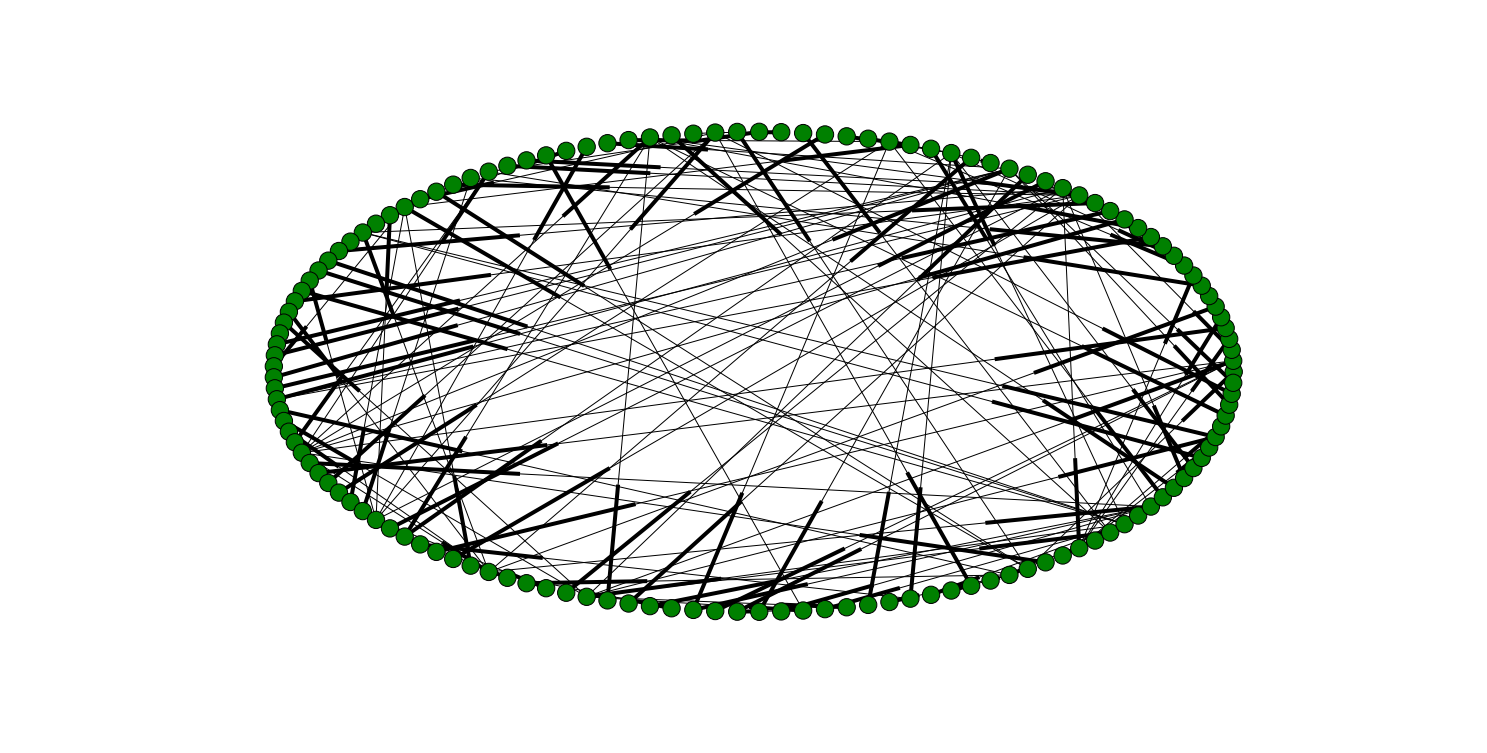

In [31]:
AllUsers = generateUsers(150)

137 rows affected.
105 rows affected.
3 rows affected.
17 rows affected.
12 rows affected.
Not possible to infect exaclty 500 users. Please chose any permutation of [3, 17, 12, 105]
272 rows affected.


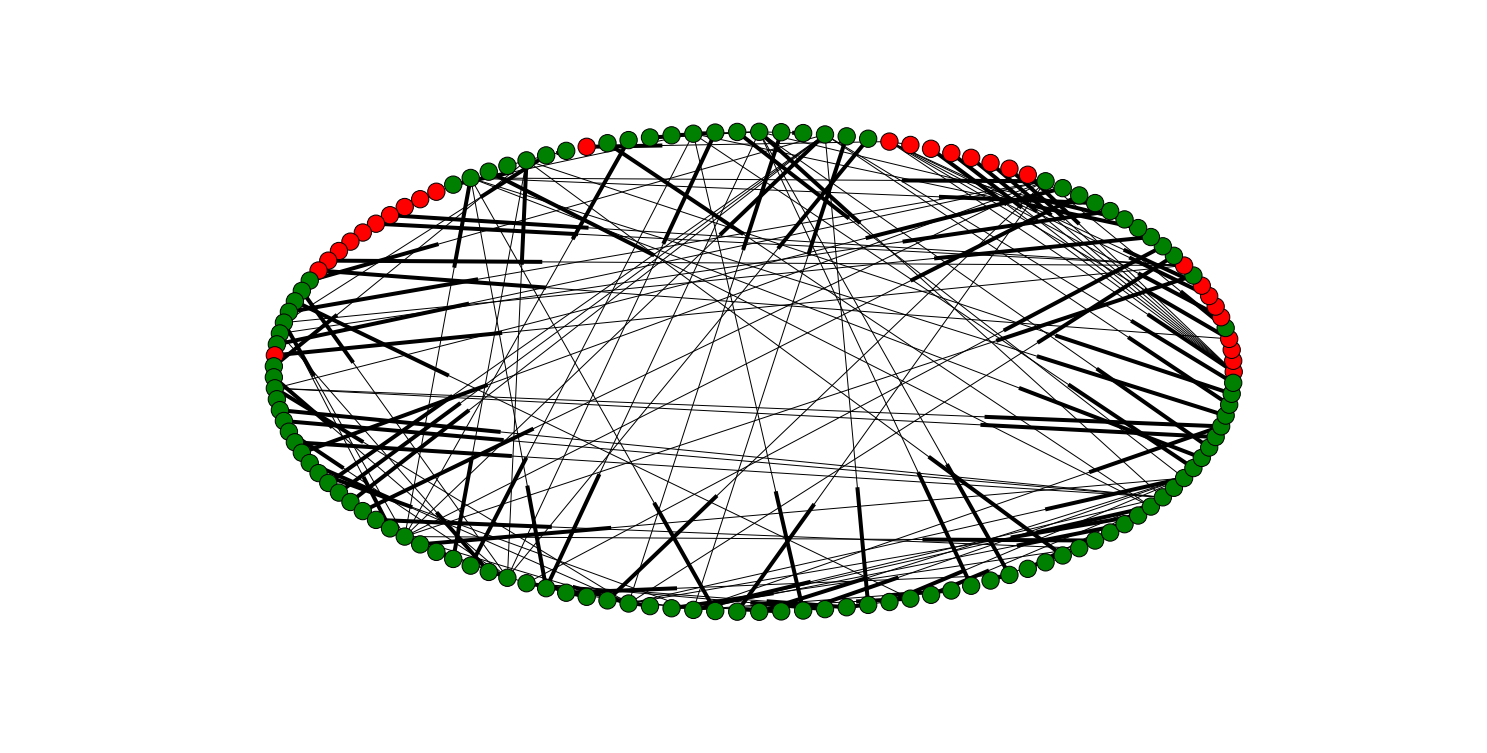

In [33]:
partial_infection(500)

272 rows affected.


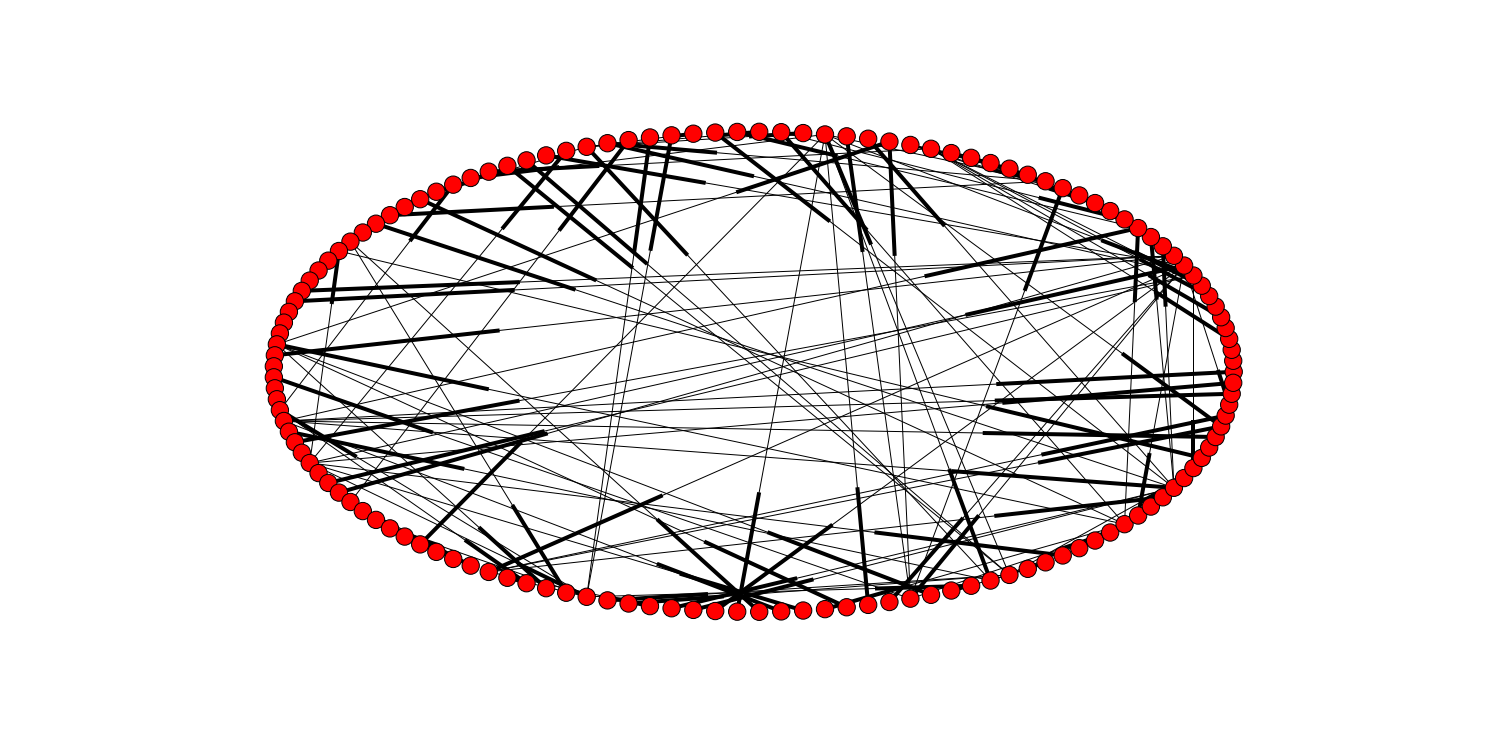

In [36]:
total_infection()

In [35]:
subgraphs = grabSubgraphs()
subgraphVals = list(subgraphs.values())


#s = [5, 7, 9, 12, 6, 3]
m = 15

chain = chain(*[combinations(subgraphVals, i) for i in range(len(subgraphVals)+1)])
combinationToInfect = [n for n in chain if sum(n) == m]

combinationToInfect

142 rows affected.
37 rows affected.
42 rows affected.
28 rows affected.
10 rows affected.
5 rows affected.
8 rows affected.
3 rows affected.
9 rows affected.


[(5, 10)]

In [34]:
from itertools import *

s = [5, 7, 9, 12, 6]
m = 15

c = chain(*[combinations(s, i) for i in range(len(s)+1)])
r = [n for n in c if sum(n) == m]

print r

[(9, 6)]


In [20]:
subgraphs = grabSubgraphs()
list(subgraphs.values())


#s = [5, 7, 9, 12, 6, 3]
#m = 15

c = chain(*[combinations(list(subgraphs.values()), i) for i in range(len(list(subgraphs.values()))+1)])
combinationToInfect = [n for n in c if sum(n) == 59]

for name, val in subgraphs.items():
    if val in combinationToInfect[0]:
        for user in AllUsers:
            if user.name == name:
                crawl(user)

142 rows affected.
83 rows affected.
50 rows affected.
4 rows affected.
5 rows affected.
Tia Jones
Ada Rodriguez
Albert Lindenpitz
Jason Vincent
David Taylor
Bill Bartlebaugh
Nora Thomas
Rosario Chapman
Carole Lout
Patricia Hass
Ruth Singelton
Daniel Mcphail
Lucy Mcalpin
Anthony Gould
Sharon Davis
Brooke Cotton
Kevin Howse
Lydia Giebler
Terri Lewis
George Adkins
Eunice Miller
Keith Donovan
Samuel Martinez
Jennifer Waters
Raymond Lopez
Sheila Mcluen
Michael Baker
David Brooks
Brittany Equils
Claire Bailey
Timothy Kinley
Walter Payne
David Lewis
Frankie Crosby
Joseph Rios
Edward Benson
Delena Mullis
Howard Renaud
Lessie Cardenas
Anita Filipiak
Marianne Williams
Sean Shell
Randy Deutsch
Jimmie Dauphin
Kevin Bell
Janice Nielsen
Dave Monaco
Erica Hawkins
Brenda Schumaker
David Riley
William Izzo
Steven Howard
Rolando Gaeta
Louise Salinas
Patsy Massengale
Andrew Franklin


In [15]:
def crawl(user):
    iuser = user
    iuser.infect()
    for u in user.coaches:
        if u.khanAcademyVersion == 'A':
            print u.name
            crawl(u)
    for u in user.students:
        if u.khanAcademyVersion == 'A':
            u.name
            print u.name
            crawl(u)

280 rows affected.


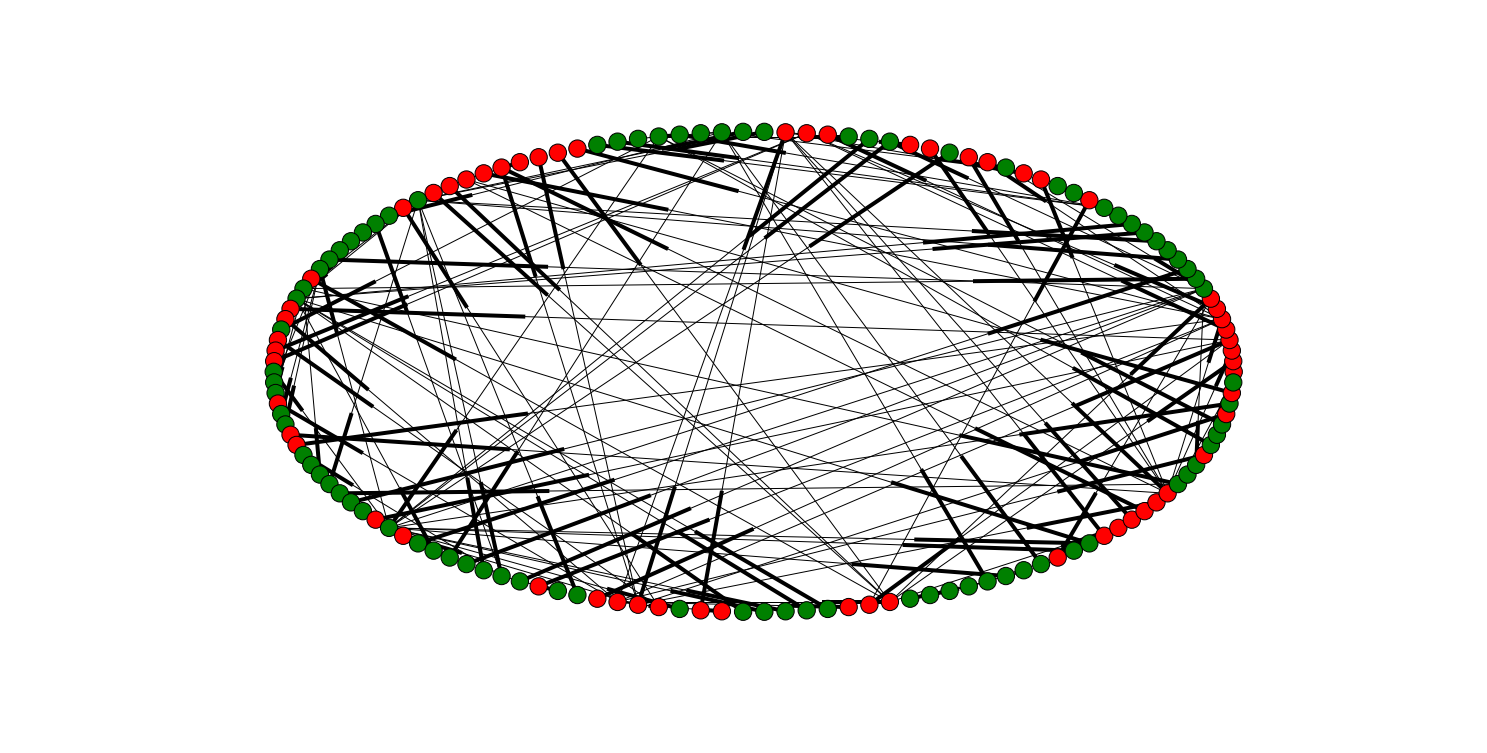

In [23]:
visualizeNXGraph()

In [97]:
def groups():
    counter = 0
    counts = []
    while (AllUsers[0] != None):
        AllUsers
        

AttributeError: 'Relationship' object has no attribute 'infect'

In [32]:
crawl(AllUsers[100])

Mavis Lutz
Hugh Batiste
Caroline Marden
Jessie Seal
Dana Gonzalez
Kimberly Cogan
Kim Hawthorne
Glenda Washington
Nicholas Mccorrison
Carole Bryant
Larry Rivera
Wanda Hansell
Lindsay Hill
Vivian Brewster
Manuel Tillman
Juan Adkins
Thomas Oneal
Robert Griffen
Louise Penaloza
Thresa Graybill
Melissa Hayes
Ricardo Himes
Elwood Douglas
Velma Baker
Brent Boyd
Francis Ewing


In [113]:
incomingRel = self.databaseNode.match_incoming(rel_type="IS_COACHING")
outgoingRel = self.databaseNode.match_outgoing(rel_type="IS_COACHING")

# create a node that is of typer UserN
self.databaseNode = Node("UserB", name = self.name, khanAcademyVersion = self.khanAcademyVersion, LastLogin = self.lastLogin)
graph.create(self.databaseNode)     

# Build the same relationships as the UserA node
for r in incomingRel:
    startNode = r.start_node
    graph.create(Relationship(startNode, "IS_COACHING", self.databaseNode))
for r in outgoingRel:
    endNode = r.end_node
    graph.create(Relationship(self.databaseNode, "IS_COACHING", endNode))

   | n                                                                
---+-------------------------------------------------------------------
 1 | (n2206:UserB {id:0,khanAcademyVersion:"B",name:"Thomas Clark"})  
 2 | (n2207:UserB {id:0,khanAcademyVersion:"B",name:"Rafael Hock"})   
 3 | (n2208:UserB {id:0,khanAcademyVersion:"B",name:"Jennifer Kalar"})

In [98]:
results = %cypher MATCH (u)-[r:IS_COACHING]-(n) RETURN u.name, r, n.name

g = results.get_graph()
plt.figure(figsize=(20,10))
g = nx.path_graph(1000)
nx.draw(g,dim=3,pos=nx.spring_layout(g), center=None)

421 rows affected.


ImportError: ('requires pygraphviz ', 'http://networkx.lanl.gov/pygraphviz ', '(not available for Python3)')

In [55]:

from itertools import *
subgraphs = grabSubgraphs()
list(subgraphs.values())


#s = [5, 7, 9, 12, 6, 3]
#m = 15

chain = chain(*[combinations(list(subgraphs.values()), i) for i in range(len(list(subgraphs.values()))+1)])
combinationToInfect = [n for n in chain if sum(n) == 38]

for name, val in subgraphs.items():
    if val in combinationToInfect[0]:
        print name
        
subgraphs
print combinationToInfect

142 rows affected.
37 rows affected.
42 rows affected.
28 rows affected.
10 rows affected.
5 rows affected.
8 rows affected.
3 rows affected.
9 rows affected.
Joel Johnson
Timothy Pai
[(28, 10)]


421 rows affected.


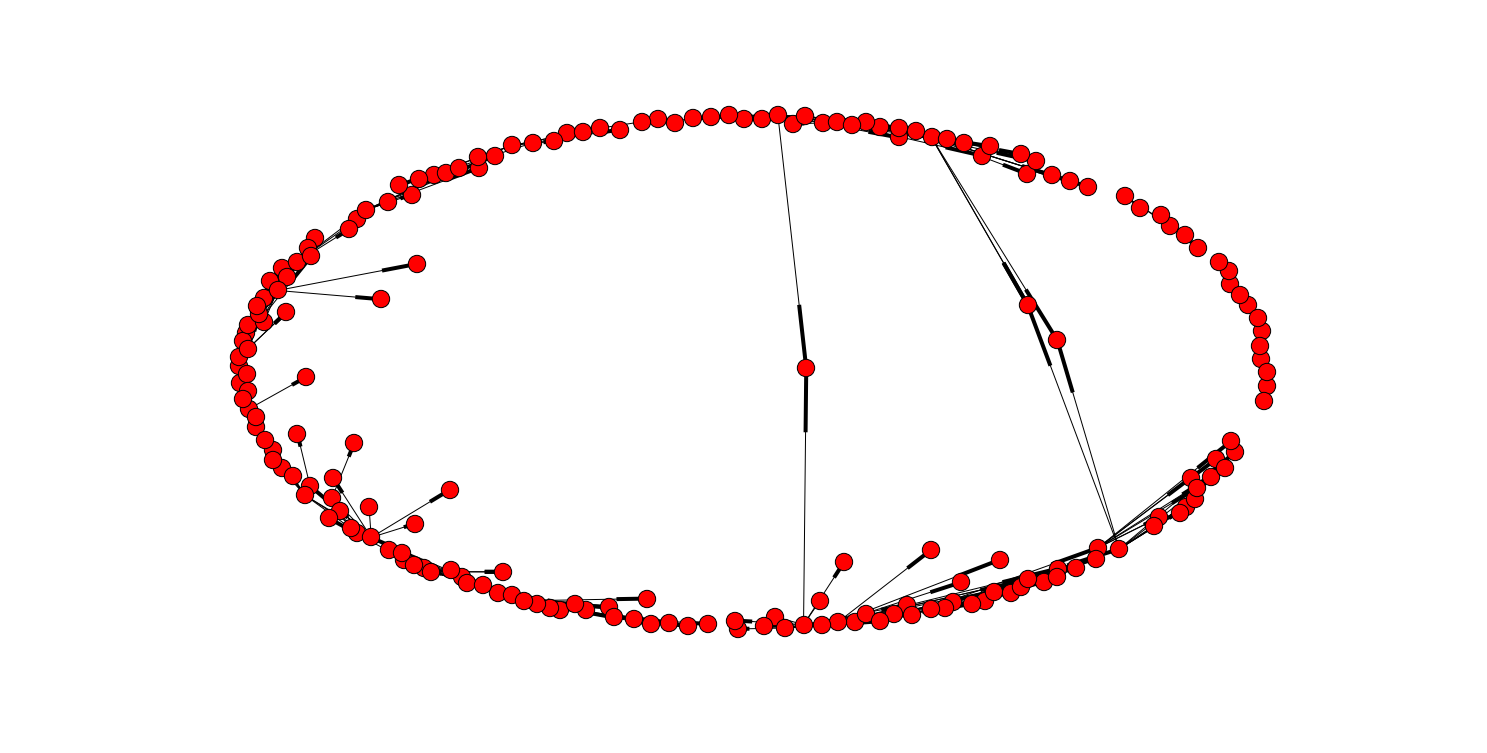

In [134]:
results = %cypher MATCH (u)-[r:IS_COACHING]-(n) RETURN u.name, r, n.name

g = results.get_graph()
plt.figure(figsize=(20,10))
nx.draw(g)


In [ ]:
allnodes = %cypher match node return node
subgraph = %cypher MATCH p=(n { name: 'Susan Williams'})-[r*0..]-(m) WITH NODES(p) AS nodes UNWIND nodes AS node RETURN DISTINCT node
allnodes = allnodes.get_dataframe()
subgraph = subgraph.dataframe
allnodes

In [41]:
allnodes = cypher.execute("match n return n")
disjointSubgraph = cypher.execute("MATCH p=(n { name: 'Susan Williams'})-[r*0..]-(m) WITH NODES(p) AS nodes UNWIND nodes AS node RETURN DISTINCT node")


[u'n']

In [21]:
nodes = %cypher match node return node
nodes = nodes.dataframe
allnodes=[]
for index, row in nodes.iterrows():
        allnodes.append(row[0])
subgraphChunks = {}
while(len(allnodes) > 0):
    name = unicodedata.normalize('NFKD', allnodes[0]['name']).encode('ascii','ignore')
    subgraph = %cypher MATCH p=(n { name: {name}})-[r*0..]-(m) WITH NODES(p) AS nodes UNWIND nodes AS node RETURN DISTINCT node
    subgraph = subgraph.dataframe
    subarray = []
    for index, row in subgraph.iterrows():
        subarray.append(row[0])
    allnodes = filter(lambda x:x not in subarray, allnodes)
    subgraphChunks[name] = len(subarray)
    #chunk = [name, len(subarray)]
    #subgraphChunks.append(chunk)
    
subgraphChunks

142 rows affected.
37 rows affected.
42 rows affected.
28 rows affected.
10 rows affected.
5 rows affected.
8 rows affected.
3 rows affected.
9 rows affected.


{'Joel Johnson': 28,
 'Margaret Huff': 3,
 'Mitchell Sutherland': 42,
 'Nancy Hope': 8,
 'Patricia Yontz': 5,
 'Penny Arnot': 37,
 'Steven Zafar': 9,
 'Timothy Pai': 10}

In [136]:
subgraphChunks[0][0]

'Gina Mckenzie'

In [23]:
node = filter(lambda x:x.name in sum(subgraphChunks, []), AllUsers)
node[0].name

TypeError: can only concatenate list (not "str") to list

In [58]:
AllUsers['name']

TypeError: list indices must be integers, not str

In [44]:
s = [5, 7, 9, 12, 6, 3]
m = 66

c = chain(*[combinations(s, i) for i in range(len(s)+1)])
r = [n for n in c if sum(n) == m]

if len(r) == 0:
    print "No available combination"
else:
    print r

No available combination


In [ ]:
%%cypher
MATCH p=(n { name: "Chad Calhoun" })-[r*0..]-(m)
WITH NODES(p) AS nodes
UNWIND nodes AS node
RETURN DISTINCT node